## Imports and Defs

### Imports

In [6]:
import requests
from bs4 import BeautifulSoup
import zipfile
import os
import io

from urllib.parse import urljoin
from io import BytesIO
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
import copy
import unidecode
import string
from tqdm import tqdm

import time
import datetime
import pickle


### Variables

In [7]:
prefix = 'dfp'
radical = 'cia_aberta'
extension = '.zip'
demo_cvmnstracoes_financeiras = ['DRA', 'DMPL', 'DFC_MD', 'DFC_MI', 'BPA', 'BPP', 'DRE', 'DVA']  # Add all other items
demo_cvmnstracoes_financeiras_dict = {
    'BPA': 'Balanço Patrimonial Ativo (BPA)',
    'BPP': 'Balanço Patrimonial Passivo (BPP)',
    'DFC_MD': 'demo_cvmnstração de Fluxo de Caixa - Método Direto (DFC-MD)',
    'DFC_MI': 'demo_cvmnstração de Fluxo de Caixa - Método Indireto (DFC-MI)',
    'DMPL': 'demo_cvmnstração de Mutações do Patrimônio Líquido (DMPL)',
    'DRA': 'demo_cvmnstração de Resultado Abrangente (DRA)',
    'DRE': 'demo_cvmnstração de Resultado (DRE)',
    'DVA': 'demo_cvmnstração de Valor Adicionado (DVA)'
}
base_de_consolidacao = ['ind', 'con']  # Add other variables if existing
base_de_consolidacao_dict = {
    'ind': 'Individual',
    'con': 'Consolidado'
}



In [8]:
# ALL VARIABLES
global duration
duration = time.time()

# variables 0
url = 'https://sistemaswebb3-listados.b3.com.br/listedCompaniesPage/?language=pt-br' 
search_url = 'https://sistemaswebb3-listados.b3.com.br/listedCompaniesPage/search?language=pt-br' 
start = 1
batch = 120
bins = 20
bin_size = 50
chunksize = 10**6  # Adjust this value based on your available memory

# variables 1
app_folder = 'datasets/'
cols_b3_companies = ['pregao', 'company_name', 'cvm', 'listagem', 'ticker', 'tickers', 'asin', 'cnpj', 'site', 'setor', 'subsetor', 'segmento', 'atividade', 'escriturador', 'url']
cols_b3_tickers = ['ticker', 'company_name']
cols_world_markets = ['symbol', 'shortName', 'longName', 'exchange', 'market', 'quoteType']
cols_yahoo = {'symbol': 'str', 'shortName': 'str', 'longName': 'str', 'exchange': 'category', 'market': 'category', 'quoteType': 'category', 'ticker': 'str', 'exchange_y': 'category', 'tick_y': 'str', 'tick': 'str'}
cols_info = ['symbol', 'shortName', 'longName', 'longBusinessSummary', 'exchange', 'quoteType', 'market', 'sector', 'industry', 'website', 'logo_url', 'country', 'state', 'city', 'address1', 'phone', 'returnOnEquity', 'beta3Year', 'beta', 'recommendationKey', 'recommendationMean']
cols_nsd = ['company', 'dri', 'dri2', 'dre', 'data', 'versao', 'auditor', 'auditor_rt', 'cancelamento', 'protocolo', 'envio', 'url', 'nsd']
cols_dre = ['Companhia', 'Trimestre', 'Demonstrativo', 'Conta', 'Descrição', 'Valor','Url']
cols_dre_math = ['Companhia', 'Trimestre', 'Demonstrativo', 'Conta', 'Descrição', 'Valor', 'Url', 'nsd']

demo = ['Demonstrações Financeiras Padronizadas', 'Informações Trimestrais']
cmbGrupo = ['Dados da Empresa']
cmbQuadro = ['Demonstração do Resultado', 'Balanço Patrimonial Ativo', 'Balanço Patrimonial Passivo', 'Demonstração do Fluxo de Caixa', 'Demonstração de Valor Adicionado', 'Demonstração do Resultado Abrangente']

last_quarters = ['3', '4']
all_quarters = ['6', '7']

# dre new columns
fsdemo = 'FS_Demonstrativo'
fsdesc = 'FS_Descrição'
fscol = 'FS_Conta'
fsval = 'FS_Valor'

columns = ['Companhia', 'Trimestre', 'Demonstrativo', 'Conta', 'Descrição', 'Valor', 'Url', 'nsd', 'demosheet']
columns = ['Companhia', 'Trimestre', 'Demonstrativo', 'Conta', 'Descrição', 'Valor', 'Url', 'nsd']

# variables 2
driver_wait_time = 2
driver = wait = None
def set_driver_and_wait(new_driver, new_wait):
    global driver, wait
    driver = new_driver
    wait = new_wait

# variables 3
local_path = os.curdir + '/'
data_path = local_path + app_folder
# data_path = check_or_create_folder(data_path)
# raw_data_path = data_path + 'raw/'
# raw_data_path = check_or_create_folder(raw_data_path)

# google cloud storage gcs
json_key_file = 'credentials\storage admin.json'
bucket_name = 'b3_bovespa_bucket'

# dre_cvm variables
base_cvm = "https://dados.cvm.gov.br/dados/CIA_ABERTA/"
xpath_cvm = '/html/body/div[1]/pre'

start_year = 2010
session = requests.Session() # Inicializar uma sessão
filelist = [] # Lista para armazenar links de arquivos CSV e ZIP
visited_subfolders = set() # Conjunto para armazenar subpastas já visitadas
# system stages


### Defs

In [9]:
# ALL DEFS

def save_pkl(data, filename):
    """Saves data to a pickle file.

    Args:
        data: The data to be saved.
        filename (str): The name of the pickle file (excluding the '.pkl' extension).

    Returns:
        The input data.
    """
    with open(f'{filename}.pkl', 'wb') as f:
        pickle.dump(data, f)
    # with zipfile.ZipFile(f'{filename}.zip', 'w', compression=zipfile.ZIP_DEFLATED) as zipf:
    #     # Save the data as a Pickle file within the zip archive
    #     with zipf.open(f'{filename}.pkl', 'w') as data_file:
    #         pickle.dump(data, data_file)

    return data

def load_pkl(filename):
    """Loads data from a pickle file.

    Args:
        filename (str): The name of the pickle file (excluding the '.pkl' extension).

    Returns:
        The loaded data.
    """
    with open(f'{filename}.pkl', 'rb') as f:
        data = pickle.load(f)
    # with zipfile.ZipFile(f'{filename}.zip', 'r') as zipf:
    #     with zipf.open(f'{filename}.pkl', 'r') as data_file:
    #         data = pickle.load(data_file)

    return data

def create_demo_file():
    """Creates a demo dictionary by loading pickled dataframes for each year.

    Args:
        start_year (int): The starting year for loading dataframes.

    Returns:
        dict: A dictionary containing loaded demo dataframes for each year.
    """
    try:
        cvm_new = {}
        years = range(b3.start_year, datetime.datetime.now().year + 1)
        start_time = time.time()

        for i, year in enumerate(years):
            print(remaining_time(start_time, len(years), i))
            dataframe = load_pkl(f'{b3.app_folder}dataframe_{year}')
            cvm_new[year] = dataframe
    except Exception as e:
        # print(e)
        pass
    return cvm_new

def gather_links(url):
  """
  Recursively gathers links to files with specific extensions from a given URL.

  Args:
    url (str): The URL to start gathering links from.
    base_url (str): The base URL to filter links.
    visited_subfolders (set): A set to keep track of visited subfolders.
    filelist (list): A list to store the gathered file links.

  Returns:
    list: A list of gathered file links.
  """

  b3.visited_subfolders.add(url)  # Marcar a subpasta como visitada
  response = b3.session.get(url)
  response.raise_for_status()
  soup = BeautifulSoup(response.content, "html.parser")

  for link in soup.find_all("a"):
    href = link.get("href")
    full_link = urljoin(url, href)

    if full_link.startswith(b3.base_cvm) and full_link not in b3.visited_subfolders:
      if full_link.endswith((".csv", ".zip", ".txt")):
        b3.filelist.append(full_link)
      elif full_link.endswith("/"):
        gather_links(full_link)
  return b3.filelist

def extract_meta(content):
    """
    Extracts metadata from content using specific formatting patterns.

    This function extracts metadata from the provided content, assuming the content
    follows a certain pattern where metadata blocks are separated by "-----------------------"
    and each block contains metadata fields with "Campo" and "Descrição" entries.

    Args:
        content (str): The content from which metadata needs to be extracted.

    Returns:
        dict: A dictionary containing extracted metadata, where keys are metadata field names ("Campo")
              and values are corresponding descriptions ("Descrição").

    Example:
        If content contains metadata in the following format:
        -----------------------
        Campo: Field1
        Descrição: Description for Field1
        -----------------------
        Campo: Field2
        Descrição: Description for Field2
        -----------------------
        The function would return: {'Field1': 'Description for Field1', 'Field2': 'Description for Field2'}
    """
    meta_dict = {}
    blocks = content.split("-----------------------\r\nCampo: ")[1:]
    
    for block in blocks:
        lines = block.strip().split("\r\n")
        campo = lines[0]
        descricao = None
        
        for line in lines:
            if 'Descrição' in line or 'Descrio' in line:
                descricao = line.split(':')[1].strip()
                break
        
        if descricao is not None:
            meta_dict[campo] = descricao
    
    return meta_dict

def get_metadados(filelist):
    """
    Extracts and processes metadata from files in the provided list of file links.

    This function takes a list of file links as input and processes the files to extract metadata.
    It specifically targets files with "meta" in their links and supports both zip files and text files.
    For zip files, it extracts metadata from each file within the zip archive.
    For text files, it decodes the content using 'iso-8859-1' encoding and extracts metadata.

    Args:
        filelist (list): A list of file links containing files with metadata.

    Returns:
        dict: A dictionary containing extracted metadata, where keys are extracted from filenames
              and values are metadata extracted from the corresponding files.

    Raises:
        requests.exceptions.HTTPError: If there is an HTTP error while fetching file content.
    """
    meta_dict = {}
    meta_files = [filelink for filelink in filelist if "meta" in filelink]

    for file in meta_files:
        response = b3.session.get(file)
        response.raise_for_status()

        if file.endswith('.zip'):
            zip_file = zipfile.ZipFile(io.BytesIO(response.content))

            for filein_zip in zip_file.namelist():
                with zip_file.open(filein_zip) as zip_filecontent:
                    filecontent = zip_filecontent.read().decode('utf-8', errors='ignore')
                    d = extract_meta(filecontent)
                    meta_dict[filein_zip.split('.')[0]] = d
        elif file.endswith('.txt'):
            filecontent = response.content.decode('iso-8859-1')
            d = extract_meta(filecontent)
            filename = file.split('/')[-1].split('.')[0]
            meta_dict[filename] = d

    return meta_dict

def get_categories(filelist):
    """
    Extracts and returns categories from a list of file links.

    This function extracts categories from the provided list of file links by considering
    the directory structure relative to the base URL. It sorts and returns a list of unique categories.

    Args:
        filelist (list): A list of file links.

    Returns:
        list: A sorted list of unique categories derived from the file links.

    Example:
        If filelist contains file links like:
        ["https://example.com/files/category1/file1.csv", "https://example.com/files/category2/file2.csv"]
        The function would return: ['category1', 'category2']
    """
    categories = set()
    # meta_files = [filelink for filelink in filelist if "meta" in filelink]
    # files = [filelink for filelink in filelist if "meta" not in filelink]

    for filelink in filelist:
        cat = '/'.join(filelink.replace(b3.base_cvm,'').split('/')[:-2])
        categories.add(cat)
    categories = sorted(list(categories))

    return categories

def get_filelink_df(base_cvm):
    """
    Retrieves file links and associated dates from a list of URLs.

    This function takes a list of URLs (filelist) and extracts folder URLs from the list.
    It then visits each folder URL, extracts file information using an XPath expression,
    and filters the information based on the current year.
    
    Args:
        filelist (list): A list of URLs containing file links.

    Returns:
        pandas.DataFrame: A DataFrame containing file names and dates for the current year.
    """
    print(f'... connecting to web "{base_cvm}"')
    print(f'    to get list of available files for download')
    filelist = gather_links(base_cvm)
    folders = set()

    # Extract folder URLs from file links
    for url in filelist:
        folder_url = '/'.join(url.split('/')[:-1])
        folders.add(folder_url)

    fileinfo_df = []
    start_time = time.time()
    # Loop through folder URLs and extract file information
    for i, url in enumerate(folders):
        print(remaining_time(start_time, len(folders), i))
        response = requests.get(url)
        response.raise_for_status()
        tree = html.fromstring(response.content)
        contents = tree.xpath(b3.xpath_cvm) 

        # Extract content and process file information
        for content in contents:
            lines = content.text_content().split('\r\n')
            for line in lines:
                parts = line.split()
                if len(parts) >= 3:
                    filename = url + '/' + parts[0]
                    date = pd.to_datetime(f'{parts[1]}', format='%d-%b-%Y')
                    fileinfo_df.append([filename, date])

    # Create and filter DataFrame for the current year
    fileinfo_df = pd.DataFrame(fileinfo_df, columns=['filename', 'date'])

    return fileinfo_df

def download_database(filelist_df, types=['itr', 'dfp']):
    """
    Downloads and processes database files based on specified DEMONSTRATIVO values.

    This function takes a list of DEMONSTRATIVO values and a DataFrame containing file information.
    It downloads and processes database files associated with the specified DEMONSTRATIVO values.
    The downloaded CSV files are extracted, metadata is extracted from filenames, and data is loaded
    into pandas DataFrames with added metadata columns.

    Args:
        cvm_news (list): A list of DEMONSTRATIVO values to filter files.
        filelist_df (pandas.DataFrame): A DataFrame containing file names and dates.

    Returns:
        list: A list of pandas DataFrames containing processed database files.
    """
    filelist = filelist_df['filename'].to_list()
    total_size = 0  
    total_size_csv = 0
    total_rows = 0
    dataframes = []
    start_time = time.time()

    # Iterate through DEMONSTRATIVO values
    for i, demonstrativo in enumerate(types):
        print(remaining_time(start_time, len(types), i))
        # Retrieve the list of files based on the specified 'DEMONSTRATIVO'
        download_files = [filelink for filelink in filelist if 'meta' not in filelink and demonstrativo in filelink]

        # Iterate through the list of URLs
        start_time_2 = time.time()
        for j, zip_url in enumerate(download_files):
            print('  ' + remaining_time(start_time_2, len(download_files), j))
            response = requests.get(zip_url)

            # Check if the download was successful
            if response.status_code == 200:
                # Get the size of the downloaded file
                filesize = len(response.content) / (1024 ** 2)
                total_size += filesize

                # Extract the zip file in memory
                with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
                    # Iterate through the files in the zip
                    start_time_3 = time.time()
                    for k, fileinfo in enumerate(zip_ref.infolist()):
                        print('  ' + '  ' + remaining_time(start_time_3, len(zip_ref.infolist()), k))
                        # Check if the file is a CSV
                        if fileinfo.filename.lower().endswith('.csv'):
                            # Extract the CSV file
                            csv_content = zip_ref.read(fileinfo.filename)
                            csv_filename = os.path.basename(fileinfo.filename)

                            # Extract metadata from the CSV filename
                            meta_csv = csv_filename.replace('cia_aberta_', '').replace('.csv', '').split('_')
                            ano = meta_csv[-1]
                            demonstrativo = meta_csv[0]
                            meta_csv = meta_csv[1:-1]
                            if len(meta_csv) > 0:
                                agrupamento = meta_csv[-1]
                                meta_csv = meta_csv[:-1]
                            else:
                                agrupamento = ''
                            balance_sheet = '_'.join(meta_csv)

                            # Read CSV content into a pandas DataFrame
                            csv_data = pd.read_csv(io.BytesIO(csv_content), encoding='iso-8859-1', sep=';')

                            # Add metadata columns to the DataFrame
                            csv_data.insert(0, 'FILENAME', csv_filename)
                            csv_data.insert(1, 'DEMONSTRATIVO', demonstrativo)
                            csv_data.insert(2, 'BALANCE_SHEET', balance_sheet)
                            csv_data.insert(3, 'ANO', ano)
                            csv_data.insert(4, 'AGRUPAMENTO', agrupamento)

                            # Append the DataFrame to the list
                            dataframes.append(csv_data)
                            total_rows += len(csv_data)

    print(f'Total {len(dataframes)} databases found and {total_rows} lines downloaded')
    return dataframes

def clean_cell(cell):
    """
    Removes specified words from a cell content.

    This function takes a cell content (string) and removes specified words from it.
    The words to remove are defined in the 'words_to_remove' list.

    Args:
        cell (str): The content of the cell to be cleaned.

    Returns:
        str: The cleaned cell content without the specified words.
    """
    words_to_remove = ['  EM LIQUIDACAO', ' EM LIQUIDACAO', ' EXTRAJUDICIAL', '  EM RECUPERACAO JUDICIAL', '  EM REC JUDICIAL', ' EM RECUPERACAO JUDICIAL']
    for word in words_to_remove:
        if word in cell:
            cell = cell.replace(word, '').strip()
    return cell

def adjust_vl_conta(row):
    if row['ESCALA_MOEDA'] == 'MIL':
        row['VL_CONTA'] = row['VL_CONTA'] * 1000
        row['ESCALA_MOEDA'] = 'UNIDADE'

    return row

def yearly(df_list):
    """
    Organizes a list of DataFrames by year.

    This function takes a list of DataFrames and organizes them by year based on the 'DT_REFER' column.
    It creates a dictionary where keys represent years and values are lists of DataFrames for each year.
    It then concatenates the DataFrames within each year's list and returns the organized dictionary.

    Args:
        df_list (list): A list of DataFrames to be organized.

    Returns:
        dict: A dictionary where keys are years and values are concatenated DataFrames for each year.
    """
    df_y = {}
    start_time = time.time()
    # Iterate through each DataFrame in the 'df_list'
    for i, df in enumerate(df_list):
        # Get the year from the 'DT_REFER' column
        year = pd.to_datetime(df['DT_REFER']).dt.year.iloc[0]
        print(year, remaining_time(start_time, len(df_list), i))

        # Check if the year is already a key in the dictionary, if not, create a list for it
        if year not in df_y:
            df_y[year] = []
        
        # Append the DataFrame to the list for the respective year
        df_y[year].append(df)

    print('... concatenating')
    start_time = time.time()

    # Concatenate DataFrames within each year's list
    for i, (year, df_list) in enumerate(df_y.items()):
        print(year, remaining_time(start_time, len(df_y), i))
        df_y[year] = pd.concat(df_list, ignore_index=True)

    return df_y

def clean_dataframe(dict_of_df):
    """
    Cleans and preprocesses DataFrames in a dictionary.

    This function takes a dictionary of DataFrames and performs various cleaning operations on each DataFrame.
    It removes extra rows, cleans up text columns, converts specified columns to datetime format,
    and applies a text cleaning function to specific columns.

    Args:
        dict_of_df (dict): A dictionary where keys are years and values are DataFrames.

    Returns:
        dict: A dictionary with cleaned and preprocessed DataFrames.
    """
    # Change data types for columns
    category_columns = ['FILENAME', 'DEMONSTRATIVO', 'BALANCE_SHEET', 'ANO', 'AGRUPAMENTO', 'CNPJ_CIA', 'VERSAO', 'DENOM_CIA', 'CD_CVM', 'GRUPO_DFP', 'MOEDA', 'ESCALA_MOEDA', 'CD_CONTA', 'DS_CONTA','ST_CONTA_FIXA', 'COLUNA_DF', ]
    datetime_columns = ['DT_REFER', 'DT_FIM_EXERC', 'DT_INI_EXERC', ]
    numeric_columns = ['VL_CONTA', ]

    print('... cleaning database')
    start_time = time.time()
    for i, (year, df) in enumerate(dict_of_df.items()):
        print(year, remaining_time(start_time, len(dict_of_df), i))
        
        # Remove extra rows based on specific conditions
        try:
            df = df[df['ORDEM_EXERC'] == 'ÚLTIMO']
            df = df.drop(columns=['ORDEM_EXERC'])
        except Exception as e:
            # print(e)
            pass
        
        # # Apply the condition to filter the DataFrame
        # try:
        #     df['DT_INI_EXERC'] = pd.to_datetime(df['DT_INI_EXERC'], errors='coerce')
        #     mask = (df['DT_INI_EXERC'].dt.month == 1) | (df['DT_INI_EXERC'].isna())
        #     df = df[mask].copy()  # Make a copy to avoid modifying the original DataFrame
        #     df = df.drop(columns=['DT_INI_EXERC'])
        # except Exception as e:
        #     pass
        print('pass 1')

        # Clean up text in 'DENOM_CIA' column
        try:
            df['DENOM_CIA'] = df['DENOM_CIA'].apply(clean_text)
        except Exception as e:
            pass
        # print('pass 2')

        # Convert specified columns to specified formats
        for column in df.columns:
            if column in category_columns:
                try:
                    df[column] = df[column].astype('category')
                except Exception as e:
                    pass
            elif column in datetime_columns:
                try:
                    df[column] = pd.to_datetime(df[column])
                except Exception as e:
                    pass
            elif column in numeric_columns:
                try:
                    df[column] = pd.to_numeric(df[column], errors='ignore')
                except Exception as e:
                    pass

        # adjust VL_CONTA according to ESCALA
        try:
            df['VL_CONTA'] = df.apply(adjust_vl_conta, axis=1)
        except Exception as e:
            pass
        # print('pass 3')

        dict_of_df[year] = df

    return dict_of_df

def group_by_year(dataframes):
    cvm_new = [df for df in dataframes if len(df) > 0 and ('con' in df['FILENAME'][0] or 'ind' in df['FILENAME'][0])]
    links = [df for df in dataframes if len(df) > 0 and ('con' not in df['FILENAME'][0] and 'ind' not in df['FILENAME'][0])]

    print('... split by year')
    cvm_new = yearly(cvm_new)
    links = yearly(links)

    # Rename column for consistency
    for year in links.keys():
        links[year].rename(columns={'VERSAO': 'VERSAO_LINK'}, inplace=True)

    return cvm_new, links

def get_filelist(url):
    """
    Update the cvm_new files based on new data from filelist_df.

    This function updates the cvm_new files by downloading new data based on filelist_df.
    It follows several steps to achieve this and also extracts metadata and categories.

    Args:
    None

    Returns:
    dict: Updated cvm_new data.
    dict: Metadata information.
    list: List of demonstrativos_cvm.

    """
    # Retrieve DataFrame containing file links from base_cvm URL
    filelist_df = get_filelink_df(url)
    
    # Find the maximum date in the filelist_df
    last_update2 = filelist_df['date'].max().strftime('%Y-%m-%d')

    try:
        # Read last update date from 'last_update.txt' if available, else set to '1970-01-01'
        with open(f'{b3.app_folder}last_update.txt', 'r') as f:
            last_update = f.read().strip()
        if not last_update:
            last_update = '1970-01-01'
    except Exception as e:
        last_update = '1970-01-01'

    # Filter filelist_df to include only files with dates greater than last_update
    filelist_df = filelist_df[filelist_df['date'] > (pd.to_datetime(last_update) + pd.DateOffset(days=1))]
    print(f'{len(filelist_df)} new files to download')

    return filelist_df, last_update2

def create_cvm(base_cvm):
    filelist_df, last_update = get_filelist(base_cvm)
    dataframes = download_database(filelist_df)
    cvm_new, links = group_by_year(dataframes)
    cvm_new = clean_dataframe(cvm_new)
    
    # Save last_update
    if len(cvm_new) > 0:
        cvm_new = save_pkl(cvm_new, f'{b3.app_folder}cvm_new')

    # Get metadata and categories from filelist
    try:
        meta_dict = get_metadados(filelist_df['filename'].to_list())
        categories = get_categories(filelist_df['filename'].to_list())
        demonstrativos_cvm = []
        for cat in categories:
            term = 'DOC/'
            if term in cat:
                demonstrativos_cvm.append(str(cat).replace(term,'').lower())
    except Exception as e:
       pass

    try:
        # Write the maximum date from filtered filelist_df to 'last_update.txt'
        print('last update', last_update)
        with open(f'{b3.app_folder}last_update.txt', 'w') as f:
            f.write(last_update)
    except Exception as e:
        pass

    # Print results
    try:
        total_fields = sum((i + 1) * len(d) for i, d in enumerate(meta_dict.values()))
        print(f'{b3.base_cvm}')
        print(f'Encontradas {len(categories)} categorias com {len(meta_dict)} arquivos meta contendo {total_fields} campos')
        print(demonstrativos_cvm)
    except Exception as e:
        pass

    return cvm_new

def adjust_quarters(group_df):
    """
    Adjust the 'VL_CONTA' values for each quarter by subtracting the previous quarter's value.
    
    Args:
    - group_df (pd.DataFrame): A DataFrame containing quarterly data for a specific group.

    Returns:
    - pd.DataFrame: The same DataFrame with adjusted 'VL_CONTA' values.
    """
    
    # Extract the VL_CONTA values for each quarter. If a value is not present for a quarter, default to 0.
    # This ensures that the adjustments are based on the correct values even if data for a particular quarter is missing.
    q1_value = group_df.loc[group_df['DT_REFER'].dt.quarter == 1, 'VL_CONTA'].values[0] if not group_df.loc[group_df['DT_REFER'].dt.quarter == 1, 'VL_CONTA'].empty else 0
    q2_value = group_df.loc[group_df['DT_REFER'].dt.quarter == 2, 'VL_CONTA'].values[0] if not group_df.loc[group_df['DT_REFER'].dt.quarter == 2, 'VL_CONTA'].empty else 0
    q3_value = group_df.loc[group_df['DT_REFER'].dt.quarter == 3, 'VL_CONTA'].values[0] if not group_df.loc[group_df['DT_REFER'].dt.quarter == 3, 'VL_CONTA'].empty else 0
    q4_value = group_df.loc[group_df['DT_REFER'].dt.quarter == 4, 'VL_CONTA'].values[0] if not group_df.loc[group_df['DT_REFER'].dt.quarter == 4, 'VL_CONTA'].empty else 0
    
    # Calculate adjustments based on the difference between quarters.
    q4_adj = q4_value - q3_value
    q3_adj = q3_value - q2_value
    q2_adj = q2_value - q1_value

    # Apply the calculated adjustments to the DataFrame.
    group_df.loc[group_df['DT_REFER'].dt.quarter == 4, 'VL_CONTA'] = q4_adj
    group_df.loc[group_df['DT_REFER'].dt.quarter == 3, 'VL_CONTA'] = q3_adj
    group_df.loc[group_df['DT_REFER'].dt.quarter == 2, 'VL_CONTA'] = q2_adj

    return group_df

def filter_last_quarter(group_df):
    """
    Filter out rows for the second and third quarters unless the 'DT_REFER' quarter matches the 'DT_INI_EXERC' quarter.
    
    Args:
    - group_df (pd.DataFrame): A DataFrame containing quarterly data for a specific group.

    Returns:
    - pd.DataFrame: A filtered DataFrame.
    """
    
    # Create a mask to identify rows where the DT_REFER quarter is 2 or 3, but doesn't match the DT_INI_EXERC quarter.
    mask = ~group_df['DT_REFER'].dt.quarter.isin([2, 3]) | (group_df['DT_REFER'].dt.quarter == group_df['DT_INI_EXERC'].dt.quarter)
    group_df = group_df[mask]
    return group_df

def adjust_last_quarter(group_df):
    """
    For the last quarter (Q4), adjust the 'VL_CONTA' value by subtracting the sum of the values from the first three quarters.
    
    Args:
    - group_df (pd.DataFrame): A DataFrame containing quarterly data for a specific group.

    Returns:
    - pd.DataFrame: The DataFrame with adjusted 'VL_CONTA' values for Q4.
    """
    
    # Extract the 'VL_CONTA' values for the first three quarters.
    q1_value = group_df.loc[group_df['DT_REFER'].dt.quarter == 1]['VL_CONTA'].values[0] if not group_df.loc[group_df['DT_REFER'].dt.quarter == 1, 'VL_CONTA'].empty else 0
    q2_value = group_df.loc[group_df['DT_REFER'].dt.quarter == 2]['VL_CONTA'].values[0] if not group_df.loc[group_df['DT_REFER'].dt.quarter == 2, 'VL_CONTA'].empty else 0
    q3_value = group_df.loc[group_df['DT_REFER'].dt.quarter == 3]['VL_CONTA'].values[0] if not group_df.loc[group_df['DT_REFER'].dt.quarter == 3, 'VL_CONTA'].empty else 0

    # Adjust the Q4 value by subtracting the sum of Q1, Q2, and Q3 values.
    mask = group_df['DT_REFER'].dt.quarter == 4
    group_df.loc[mask, 'VL_CONTA'] -= (q1_value + q2_value + q3_value)

    return group_df

def apply_adjustments(group):
    """
    Apply the appropriate adjustment logic based on the 'BALANCE_SHEET' value of the group.
    
    Args:
    - group (pd.DataFrame): A DataFrame containing data for a specific group.

    Returns:
    - pd.DataFrame: The adjusted DataFrame.
    """
    # Lists defining the types of balance sheets:

    # 'patrimonial' refers to balance sheets that detail a company's assets and liabilities.
    # 'BPA' stands for "Balance Sheet - Active" and represents the company's assets.
    # 'BPP' stands for "Balance Sheet - Passive" and represents the company's liabilities.
    patrimonial = ['BPA', 'BPP']

    # 'resultados' refers to balance sheets that detail a company's revenues and expenses over a specific period.
    # 'DRA' stands for "Statement of Revenue - Accumulated" and represents the accumulated revenues over a year.
    # 'DRE' stands for "Statement of Revenue - Exercise" and represents the revenues for a specific financial exercise.
    resultados = ['DRA', 'DRE']

    # 'fluxo_de_caixa' refers to cash flow statements detailing the inflows and outflows of cash.
    # 'DFC_MI' represents the "Direct Method of Cash Flow - Individual".
    # 'DFC_MD' represents the "Direct Method of Cash Flow - Consolidated".
    # 'DVA' stands for "Added Value Statement".
    # 'DMPL' stands for "Statement of Changes in Equity".
    fluxo_de_caixa = ['DFC_MI', 'DFC_MD', 'DVA']

    # other stuff
    other = ['DMPL']

    sheet = group['BALANCE_SHEET'].iloc[0]
    
    # If the group's 'BALANCE_SHEET' value belongs to the fluxo_de_caixa category, apply quarter adjustments.
    if sheet in fluxo_de_caixa:
        return adjust_quarters(group)
    # If the group's 'BALANCE_SHEET' value belongs to the resultados category, filter and adjust the last quarter.
    elif sheet in resultados:
        group = filter_last_quarter(group)
        return adjust_last_quarter(group)
    # If the group's 'BALANCE_SHEET' value doesn't match the above categories, return the original group without adjustments.
    else:
        return group

def get_merged_and_math(cvm_now, cvm_new):
    """
    Merge two dictionaries of dataframes and extract updated rows.

    The function performs an outer merge on two dictionaries of dataframes, `cvm_now` (existing data) 
    and `cvm_new` (new data). The purpose is to update old financial data with new financial data and 
    to identify rows which have been updated for future mathematical transformations.

    Parameters:
    - cvm_now (dict): Dictionary with years as keys and existing financial data as values (pandas DataFrames).
    - cvm_new (dict): Dictionary with years as keys and new financial data as values (pandas DataFrames).

    Returns:
    - tuple: Two dictionaries of dataframes - the first contains the merged data, and the second contains the updated rows.

    """
    
    # Collect unique years present in both dictionaries
    all_keys = sorted(set(cvm_now.keys()).union(cvm_new.keys()))

    # Retrieve column names for the current year from cvm_now, if absent, get from cvm_new
    df_columns = cvm_now.get(min(all_keys), pd.DataFrame()).columns if min(all_keys) in cvm_now else cvm_new[min(all_keys)].columns

    # Key column to identify the main data column that could have changes
    value_column = 'VL_CONTA'

    # Define columns that serve as the unique identifier for each row in the financial data, excluding the value_column
    key_columns = [col for col in df_columns if col != value_column]

    # Initialize storage for final merged data and the rows that were updated in the new data
    cvm_merged = {}
    math = {}

    try:
        # Iterate over each unique year
        for year in all_keys:
            # Fetch corresponding DataFrames for the year from cvm_now and cvm_new, or initialize empty DataFrames if absent
            df1 = cvm_now.get(year, pd.DataFrame(columns=df_columns))
            df2 = cvm_new.get(year, pd.DataFrame(columns=df_columns))
            
            # If only new data exists for the year, directly assign it to the merged result
            if df1.empty and not df2.empty:
                cvm_merged[year] = df2
            # If only old data exists for the year and there's no new data, directly assign the old data to the merged result
            elif df2.empty and not df1.empty:
                cvm_merged[year] = df1
            # If data exists in both old and new sets, perform merging operations
            else:
                # Merge existing and new data based on the unique identifier columns. Rows from the new data are prioritized.
                df_merged = pd.merge(df1, df2, on=key_columns, how='right', suffixes=('_now', '_new'))
                
                # Identify rows that are either new or have updated 'value_column' values
                mask_diff_rows = (df_merged[f'{value_column}_now'] != df_merged[f'{value_column}_new']) | df_merged[f'{value_column}_now'].isna()
                df_math = df_merged.loc[mask_diff_rows].copy()
                
                # Loop through both merged and updated rows dataframes for further processing
                for df, result_dict in zip([df_merged, df_math], [cvm_merged, math]):
                    # Determine the 'value_column' value based on whether it's an updated/new row or an unchanged one
                    df[value_column] = np.where(
                        (df[f'{value_column}_now'] == df[f'{value_column}_new']) | df[f'{value_column}_now'].isna(),
                        df[f'{value_column}_new'], 
                        df[f'{value_column}_now']
                    )
                    
                    # Discard temporary columns used during merging
                    df.drop(columns=[f'{value_column}_now', f'{value_column}_new'], inplace=True)
                    
                    # Ensure the dataframe's columns are in the desired order
                    df = df[df_columns]
                    
                    # Store the processed dataframe in the appropriate dictionary
                    result_dict[year] = df

                # Print diagnostic information about the number of rows in the merged and updated rows data for the current year
                print(f'{year}, {df_merged.shape[0]:,.0f} existing, {df_math.shape[0]:,.0f} new lines')

    except Exception as e:
        # In case of an error, print the error message for debugging
        # print(e)
        pass

    return cvm_merged, math

def get_companies_by_str_port(df):
    """
    Get a list of companies grouped by 'ind' and 'con' in a structured report.

    Args:
        df (pd.DataFrame): DataFrame containing financial data.

    Returns:
        dict: Dictionary with keys 'ind', 'con', and ('ind', 'con') combinations
              mapped to lists of corresponding 'DENOM_CIA' values.

    This function calculates the list of companies grouped by 'ind' (individual) and 'con'
    (consolidated) in a structured report. It utilizes a pivot table to count occurrences of
    'ind' and 'con' for each company and reporting date. The resulting dictionary stores
    'ind' and 'con' as keys and their corresponding 'DENOM_CIA' values.

    Example:
        To use this function, provide a DataFrame containing financial data ('df') as input.
        The function will return a dictionary with keys 'ind', 'con', and ('ind', 'con')
        combinations, each mapped to lists of 'DENOM_CIA' values belonging to that group.
    """
    try:
       # Create a pivot table to count occurrences of 'ind' and 'con'
        pivot_table = df.pivot_table(index=['DENOM_CIA', 'DT_REFER'], columns='AGRUPAMENTO', aggfunc='size', fill_value=0)
        
        # Convert counts to boolean values (True if count > 0, else False)
        pivot_table = pivot_table.applymap(lambda x: True if x > 0 else False)
        pivot_table = pivot_table[['ind'] + [col for col in pivot_table.columns if col != 'ind' and col != 'con'] + ['con']]

        # Get unique combinations of rows as tuples
        combinations = set(map(tuple, pivot_table.to_numpy()))

        # Create a dictionary to store combinations and corresponding 'DENOM_CIA'
        companies_by_str_port = {}

        # Find matching 'DENOM_CIA' for each combination
        for combination in combinations:
            relest_individual = combination[0]
            relest_consolidado = combination[1]
            cias = pivot_table[(pivot_table['ind'] == relest_individual) & (pivot_table['con'] == relest_consolidado)].index.get_level_values('DENOM_CIA').unique()
            key = ('ind', 'con')
            if relest_consolidado and not relest_individual:
                key = 'con'
            if not relest_consolidado and relest_individual:
                key = 'ind'
        companies_by_str_port[key] = cias
    except Exception as e:
        companies_by_str_port = {('ind', 'con'): 0, 'con': 0, 'ind': 0}

    return companies_by_str_port

def wrapper_apply(group, pbar):
    """Wrapper function for applying adjustments and updating the progress bar."""
    result = apply_adjustments(group)
    pbar.update(1)  # Update the progress bar by one step
    return result

def get_adjusted_dataframes(math):
    """
    Apply adjustments to dataframes for each year in the data_dict.

    Parameters:
    - data_dict (dict): Dictionary with years as keys and financial dataframes as values.

    Returns:
    - dict: Dictionary with years as keys and adjusted dataframes as values.
    """
    # Initialize a dictionary to store the adjusted dataframes for each year
    math_new = {}

    # Loop through each year in the data dictionary
    for year, df_merged in math.items():
        # Group the DataFrame by the columns: 'DENOM_CIA', 'AGRUPAMENTO', 'CD_CONTA', and 'DS_CONTA'
        grouped = df_merged.groupby(['DENOM_CIA', 'AGRUPAMENTO', 'CD_CONTA', 'DS_CONTA'], group_keys=False)

        # Set up a progress bar to track the processing of each group
        with tqdm(total=grouped.ngroups, desc=f"Calculating quarter values for year {year}") as pbar:
            # Use a lambda to pass the progress bar to the wrapper_apply function
            adjusted_df = grouped.apply(lambda group: wrapper_apply(group, pbar)).reset_index(drop=True)
        
        # Store the adjusted dataframe in the result dictionary
        math_new[year] = adjusted_df
        math_new = save_pkl(math_new, f'{b3.app_folder}math_now')
        math_new[year] = save_pkl(math_new[year], f'{b3.app_folder}math_new_{year}')
    return math_new

def year_to_company(cvm_new):
# Get all unique companies across all years
    all_companies = set()
    for i, (year, df) in enumerate(cvm_new.items()):
        all_companies.update(df['DENOM_CIA'].unique())

    # Initialize the final dictionary with companies as keys
    companies = {}

    # Populate the company_dict
    start_time = time.time()
    try:
        for i, company in enumerate(all_companies):
        #   if company == 'ALPARGATAS SA':
            print(remaining_time(start_time, len(all_companies), i))
            company_df = []  # This will hold dataframes for each year for the company
            for j, (year, df) in enumerate(cvm_new.items()):
                company_data = df[df['DENOM_CIA'] == company]
                company_df.append(company_data)
            companies[company] = pd.concat(company_df, ignore_index=True)
    except Exception as e:
        pass    
        # Concatenate the data for the company across all years

    companies = save_pkl(companies, f'{b3.app_folder}database')
    return companies

def get_diff(df1, df2):
    # Create a mask to identify rows in df2 where 'VL_CONTA' is different from df1
    mask_diff = df1['VL_CONTA'] != df2['VL_CONTA']

    # Initialize an empty list to store DataFrames with differences
    df_math = []

    # Iterate through rows in df2 that have differences in 'VL_CONTA'
    for i, (idx, row) in enumerate(df2[mask_diff].iterrows()):
        # Print information about the difference
        print(
            f"{row['DENOM_CIA']}, {row['AGRUPAMENTO']}, {row['DT_REFER'].strftime('%Y-%m-%d')}, "
            f"Old Value: {int(df1.loc[idx, 'VL_CONTA'])} -> New Value: {int(row['VL_CONTA'])}, "
            f"{row['CD_CONTA']}, {row['DS_CONTA']}")

        # Create filters to identify rows in df2 that match the current difference
        filter_mask_cia = df2['DENOM_CIA'] == row['DENOM_CIA']
        filter_mask_agg = df2['AGRUPAMENTO'] == row['AGRUPAMENTO']
        filter_mask_conta = df2['CD_CONTA'] == row['CD_CONTA']
        filter_mask_year = df2['DT_REFER'].dt.year == row['DT_REFER'].year

        # Combine filters to create a mask for the matching rows in df2
        mask = filter_mask_cia & filter_mask_agg & filter_mask_conta & filter_mask_year

        # Append the filtered matching rows to the list
        df_math.append(df2[mask])

    # If there are matching rows, concatenate them into a single DataFrame
    if df_math:
        df_math = pd.concat(df_math, ignore_index=False)

    # Return the DataFrame containing differences
    return df_math

def create_df_math(df_old, df_new):
    year = 2019
    try:
        mask_cia = df_new[year]['DENOM_CIA'] == 'ALPARGATAS SA'
        mask_agg = df_new[year]['AGRUPAMENTO'] == 'con'
        mask_quarter = df_new[year]['DT_REFER'] == '2014-06-30'
        mask_sheet = df_new[year]['BALANCE_SHEET'] == 'BPA'
        mask_CD_CONTA = df_new[year]['CD_CONTA'] == '1'
        mask = mask_cia & mask_agg & mask_quarter & mask_sheet & mask_CD_CONTA
        df_new[year].loc[mask, 'VL_CONTA'] = 1000000.0
    except Exception as e:
        pass

    try:
        mask_cia = df_new[year+1]['DENOM_CIA'] == 'ALPARGATAS SA'
        mask_agg = df_new[year+1]['AGRUPAMENTO'] == 'con'
        mask_quarter = df_new[year+1]['DT_REFER'] == '2015-09-30'
        mask_sheet = df_new[year+1]['BALANCE_SHEET'] == 'DRE'
        mask_CD_CONTA = df_new[year+1]['CD_CONTA'] == '3.01'
        mask = mask_cia & mask_agg & mask_quarter & mask_sheet & mask_CD_CONTA
        df_new[year+1].loc[mask, 'VL_CONTA'] = 1000000.0
    except Exception as e:
        pass

    try:
        mask_cia = df_new[year+2]['DENOM_CIA'] == 'ALPARGATAS SA'
        mask_agg = df_new[year+2]['AGRUPAMENTO'] == 'con'
        mask_quarter = df_new[year+2]['DT_REFER'] == '2016-12-31'
        mask_sheet = df_new[year+2]['BALANCE_SHEET'] == 'DFC_MI'
        mask_CD_CONTA = df_new[year+2]['CD_CONTA'] == '6.01'
        mask = mask_cia & mask_agg & mask_quarter & mask_sheet & mask_CD_CONTA
        df_new[year+2].loc[mask, 'VL_CONTA'] = 1000000.0
    except Exception as e:
        pass

   # Iterate through the years and DataFrames in df_new
    # Initialize the dictionary to store differences
    df_math = {}

    for year, df in df_new.items():
        # Check if the year is in the past
        if year in df_old and df_old[year].shape == df_new[year].shape:
            # Call the get_diff function to identify and extract differences
            dfs = get_diff(df_old[year], df_new[year])
            
            # Check if there are differences found
            if len(dfs) > 0:
                # Store the differences in the dictionary using the year as the key
                df_math[year] = dfs
            else: 
                df_math[year] = df_new[year]
        else:
            # If the year is not in df_old or the shapes don't match, store the entire df_new[year]
            df_math[year] = df_new[year]

    return df_math.copy()

def merge_cvm_math(cvm_new, df_math):
    for year in cvm_new.keys():
        # Update df_cvm['VL_CONTA'] using the values from df_math['VL_CONTA']
        cvm_new[year].loc[df_math[year].index, 'VL_CONTA'] = df_math[year]['VL_CONTA']
    return cvm_new

def merge_math(math_existing, math_new):
    df1 = math_existing
    df2 = math_new

    # The key columns used to determine unique rows
    key_columns = ['DENOM_CIA', 'AGRUPAMENTO', 'CD_CONTA', 'DT_REFER']

    # Create an empty dictionary to store the merged dataframes for each year
    df_merged = {}
    try:
        # https://chat.openai.com/c/ba8fa5e3-d96f-4db6-8900-864b3561809e
        # https://chat.openai.com/c/4d86bf87-0f68-4df2-8bfc-93ee143c9cac
        # https://chat.openai.com/c/938e4bbc-0d46-4c2e-ad7e-ed07c76859b3
        # https://chat.openai.com/c/a68f7b71-fa50-4d90-9df9-f6a961acb3bf  

        # Iterate over each year present in either df1 or df2
        for year in set(df1.keys()).union(df2.keys()):
            print(year)
            # Check if the year exists in df2 (the newer dataframe)
            if year in df2:
                # Start with the data from df2 for this year
                merged_df = df2[year].copy()
                
                # Check if the year also exists in df1 (the older dataframe)
                if year in df1:
                    # Determine the rows in df1[year] that are not present in df2[year]
                    # based on the key columns
                    mask = ~df1[year].set_index(key_columns).index.isin(df2[year].set_index(key_columns).index)
                    
                    # Filter df1[year] to only these rows
                    extra_rows = df1[year][mask]
                    
                    # Use pandas.concat to combine the dataframes
                    merged_df = pd.concat([merged_df, extra_rows], ignore_index=False)
            else:
                # If the year doesn't exist in df2, then just use the data from df1
                merged_df = df1[year].copy()

            # Store the merged dataframe for this year in the df_merged dictionary
            df_merged[year] = merged_df

        # At this point, df_merged will have the merged data for each year
        # print(len(df_merged))
    except Exception as e:
       pass
    return df_merged


## Content

### math and concat math


In [ ]:
company = load_pkl(f'{app_folder}company')


In [ ]:
list(company.keys())


<Axes: xlabel='DT_REFER'>

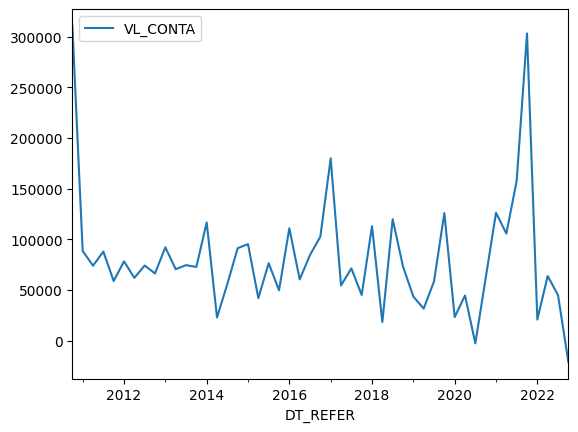

In [116]:
company_name = 'ALPARGATAS SA'
df = company[company_name]

mask_agg = df['AGRUPAMENTO'] == 'con'
mask_conta = df['CD_CONTA'] == '3.11'

mask = mask_agg & mask_conta
df[mask][['DT_REFER','VL_CONTA']].set_index('DT_REFER').plot()

In [14]:
# Step 1: Get the URL of the download link
url = "https://sistemaswebb3-listados.b3.com.br/classificationSegmentDownloadExcel"

# Step 2: Fetch the content using requests
response = requests.get(url)
response.raise_for_status()  # Raise an error if the request failed

# Step 3: Save the content to a local file
with open("listed_companies.xlsx", "wb") as f:
    f.write(response.content)


HTTPError: 404 Client Error: Not Found for url: https://sistemaswebb3-listados.b3.com.br/classificationSegmentDownloadExcel